In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import random

import warnings

warnings.filterwarnings(action='ignore')

path = '/opt/ml/input/data/'
dat = pd.read_csv(path + 'FE/FE_total_2_elo2.csv')


In [2]:
dat.drop(['day','year','KnowledgeTag', 'last_answerCode7','last_answerCode8','last_answerCode9','last_answerCode10'], axis = 1, inplace = True)

In [3]:
dat.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'elouser', 'eloitem', 'elotag', 'elotest', 'elo', 'solve_time',
       'b_category', 'test_category', 'problem_id', 'category_st_qcut_5',
       'last_answerCode', 'last_answerCode2', 'last_answerCode3',
       'last_answerCode4', 'last_answerCode5', 'last_answerCode6', 'month',
       'hour'],
      dtype='object')

In [4]:
_train = dat[dat['answerCode'] >= 0]
_test = dat[dat['answerCode'] < 0]

In [5]:
# valid 제작하는 함수 새로 개편.
# 예전 valid 제작 함수는 1분 걸렸는데 0.6초만에 끗~
_train['train_valid'] = 0
_train.loc[_train.drop_duplicates(subset='userID', keep = 'last').index, 'train_valid'] = -1
_valid = _train[_train['train_valid'] == -1]
_train = _train[_train['train_valid'] == 0]

In [11]:
_train

,userID,assessmentItemID,testId,answerCode,Timestamp,elouser,eloitem,elotag,elotest,elo,...,category_st_qcut_5,last_answerCode,last_answerCode2,last_answerCode3,last_answerCode4,last_answerCode5,last_answerCode6,month,hour,train_valid
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,0.604065,-3.354789,-2.988107,-2.915382,52.397261,...,"(-0.001, 9.0]",1,1,1,1,1,1,3,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,0.604065,-3.019619,-2.256471,-2.915382,37.475366,...,"(-0.001, 9.0]",1,1,1,1,1,1,3,0,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,0.604065,-2.311757,-2.256471,-2.915382,18.463991,...,"(-0.001, 9.0]",1,1,1,1,1,1,3,0,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,0.604065,-3.083097,-2.256471,-2.915382,39.931367,...,"(-0.001, 9.0]",1,1,1,1,1,1,3,0,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,0.604065,-2.637877,-2.256471,-2.915382,25.583371,...,"(-0.001, 9.0]",1,1,1,1,1,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526694,7441,A030071004,A030000071,0,2020-06-05 06:49:57,-0.099183,0.011644,-0.419509,-0.380745,0.895094,...,"(25.0, 56.0]",1,0,0,1,1,1,6,6,0
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,-0.099183,0.924409,-0.419509,-0.380745,0.359302,...,"(9.0, 25.0]",0,1,0,0,1,1,6,6,0
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,-0.099183,-0.412535,-0.576496,-0.444296,1.368003,...,"(237.0, 25602295.0]",0,0,1,0,0,1,8,1,0
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,-0.099183,-0.346430,-0.576496,-0.444296,1.280496,...,"(9.0, 25.0]",1,0,0,1,0,0,8,1,0


In [12]:
# 모델에 적용하기 전 기본적인 데이터 전처리 부분
## 라벨링, 필요없는 칼럼 제거
_train_value = _train['answerCode']
_train.drop(['Timestamp', 'testId', 'train_valid', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

_valid_value = _valid['answerCode']
_valid.drop(['Timestamp', 'testId', 'train_valid', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

_test.drop(['Timestamp', 'testId', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

In [13]:
# CatBoost에 적용하기 위해선 문자열 데이터로 변환 필요.
# 만약 범주형이 아니고 연속형(정수, 소수) 성질을 살리고 싶은 변수는 여기 drop에 적어두면 됨.(solve_time 같이.)
cat_columns = list(_train.drop(['solve_time','month','elo'],axis=1).columns)

for col in cat_columns:
    _train[col] = _train[col].astype('str')
    _valid[col] = _valid[col].astype('str')
    _test[col] = _test[col].astype('str')

In [14]:
#!pip install catboost
# 가상환경에 패키지 설치 필요할듯
from catboost import CatBoostClassifier

# 하이퍼파라미터 수정할 여지가 많으니 추가나 수정하고 싶은 사람 수정해도 괜찮을듯.
# 일단 지난번에 사용했던 파라미터들 주석으로 들고 옴. 참고하면서 공부하면 좋을듯.

# params_cat = {
#     "task_type" : "GPU",
#     "devices" : '0',
#     "random_state": SEED,
#     'learning_rate': 0.04574578205475402, 
#     'bagging_temperature': 0.12172958098369972, 
#     'n_estimators': 2000, 
#     'max_depth': 8, 
#     'random_strength': 28, 
#     'l2_leaf_reg': 1.6285455533915874e-05, 
#     'min_child_samples': 18, 
#     'max_bin': 441, 
#     'od_type': 'Iter',
#     "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
# }

# model = CatBoostRegressor(**params_cat)

# 실제 적용한 모델은 learning_rate, iterations(=n_estimators, 아마도?)만 사용함.
cat_model = CatBoostClassifier(learning_rate=0.05, random_state = 1998, iterations=4000, task_type="GPU", eval_metric = 'AUC',max_depth = 8,bootstrap_type = 'Bernoulli', subsample= 0.7)
cat_model.fit(_train, _train_value, early_stopping_rounds=100, cat_features=cat_columns ,verbose=200, eval_set=(_valid, _valid_value))


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8007058	best: 0.8007058 (0)	total: 281ms	remaining: 18m 43s
200:	test: 0.8360936	best: 0.8360936 (200)	total: 40s	remaining: 12m 35s
400:	test: 0.8391704	best: 0.8391800 (399)	total: 1m 17s	remaining: 11m 39s
600:	test: 0.8402471	best: 0.8402564 (599)	total: 1m 55s	remaining: 10m 52s
bestTest = 0.8407053351
bestIteration = 673
Shrink model to first 674 iterations.


In [15]:
# valid score를 확인해봄.
# train 대비 valid score가 떨어짐. 과적합이 일어남. 마찬가지로 규제하는 하이퍼파라미터 필요.
from sklearn.metrics import accuracy_score, roc_auc_score

print('train score')
_train_pred = cat_model.predict_proba(_train)[:,1]
print(roc_auc_score(_train_value, _train_pred)) # auc
print(accuracy_score(_train_value, np.where(_train_pred >= 0.5, 1, 0))) # acc, 정확도

print('valid score')
_valid_pred = cat_model.predict_proba(_valid)[:,1]
print(roc_auc_score(_valid_value, _valid_pred)) # auc
print(accuracy_score(_valid_value, np.where(_valid_pred >= 0.5, 1, 0))) # acc, 정확도

train score
0.8890403333225348
0.825698407870673
valid score
0.8407053824917474
0.764041924213921


Text(0.5, 1.0, 'Feature Importance')

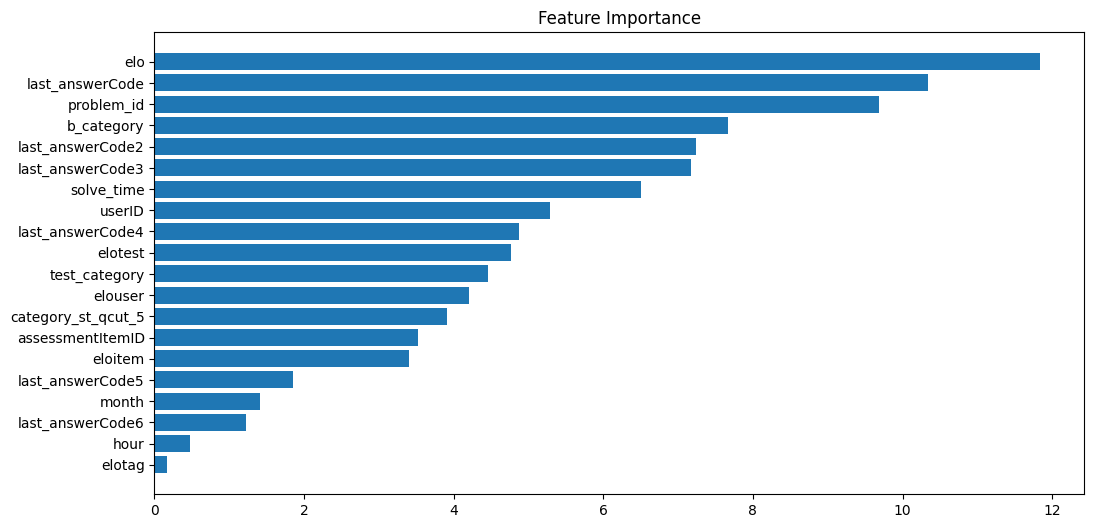

In [16]:
import matplotlib.pyplot as plt

feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(_valid.columns)[sorted_idx])
plt.title("Feature Importance")

In [17]:
# submission 제출하기 위한 코드

_test_pred = cat_model.predict_proba(_test)[:,1]
_test['prediction'] = _test_pred
submission = _test['prediction'].reset_index(drop = True).reset_index()
submission.rename(columns = {'index':'id'}, inplace = True)
submission.to_csv('../output/cat3.csv', index = False)

In [18]:
submission

,id,prediction
0,0,0.620660
1,1,0.660555
2,2,0.174870
3,3,0.689929
4,4,0.276513
...,...,...
739,739,0.006001
740,740,0.752712
741,741,0.899806
742,742,0.886922
